In [494]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

import math
from tqdm import tqdm
from itertools import chain, combinations

# Преобразование Бокса-Кокса

Если случайная величина имеет логнормальное распределение, то ее логарифм имеет нормальное распределение.

In [495]:
data_log = pd.Series(np.random.lognormal(0, 1, 1000))

<Axes: >

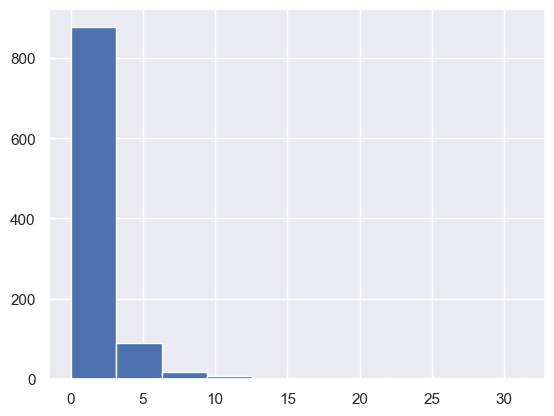

In [496]:
data_log.hist()

<Axes: >

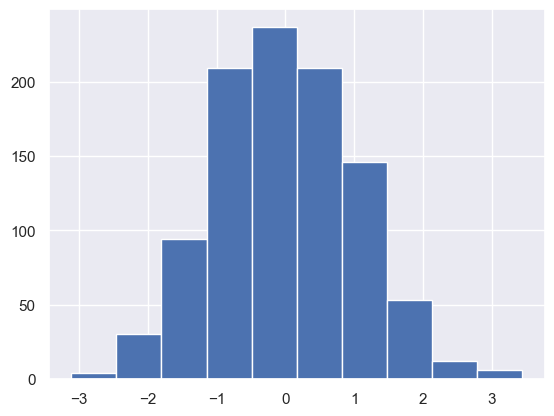

In [497]:
np.log(data_log).hist()

Почему это работает?

FigureCanvasAgg is non-interactive, and thus cannot be shown


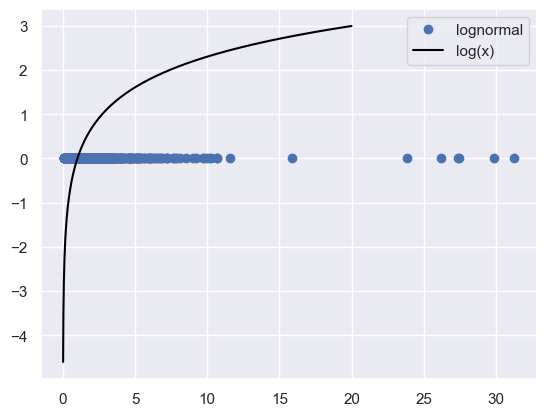

In [498]:
log_x = np.arange(0.01, 20, 0.01)
log_y = np.log(log_x)

x_points = data_log
y_points = np.zeros(1000)

fig = plt.figure()
plt.plot(x_points, y_points, 'o', label="lognormal")
plt.plot(log_x, log_y, 'black', label='log(x)')

plt.legend()

fig.show()

Если экспоненциальное распределение?

In [499]:
data_exp = pd.Series(np.random.exponential(size=1000))

<Axes: >

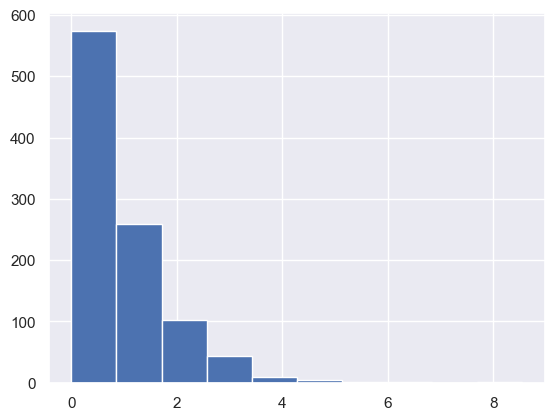

In [500]:
data_exp.hist()

<Axes: >

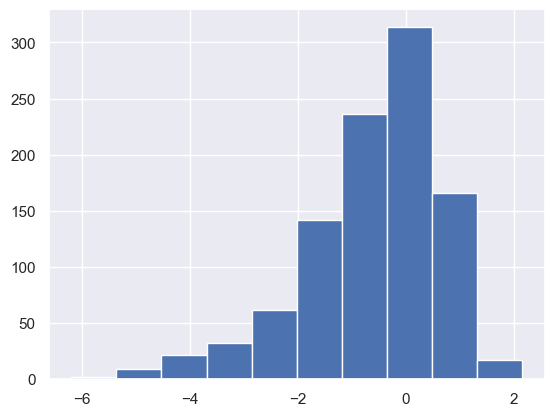

In [501]:
np.log(data_exp).hist()

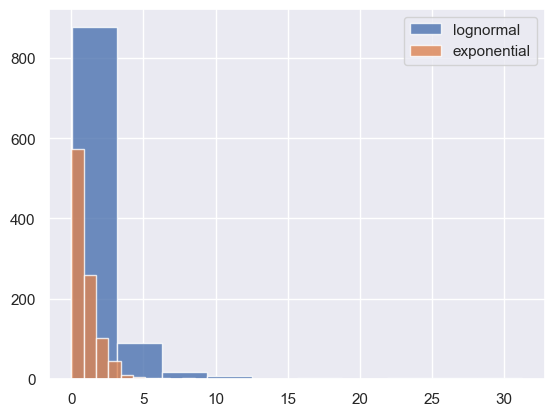

In [502]:
plt.hist(data_log, label='lognormal', alpha=.8)
plt.hist(data_exp, label='exponential', alpha=.8)
plt.legend()

plt.show()

Найдем такое преобразование.

$$\int\frac{1}{x^{1-\lambda}}=\frac{x^\lambda-1}{\lambda}+C,$$
где $\lambda$ - искомый параметр.

$$x^*_i=\begin{cases}
\ln(x), & \lambda=0 \\
\frac{x^\lambda-1}{\lambda}, & \text{в обратном случае.}
\end{cases}$$

In [503]:
from scipy.stats import boxcox
transformed_data, best_lambda = boxcox(data_exp)

<Axes: >

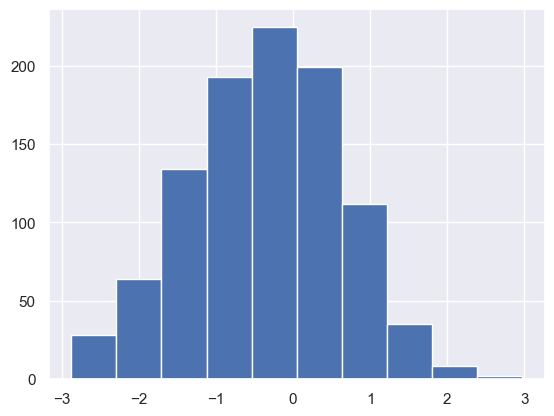

In [504]:
pd.Series(transformed_data).hist()

In [505]:
best_lambda

0.2892658953492926

# Отбор признаков

In [506]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
X = df.drop(["target", "index"], axis=1)
y = df[["target"]]

In [507]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

## Корреляционный анализ

In [508]:
train_X.columns

Index(['back-suspension', 'battery-capacity', 'charge-time', 'compression',
       'consumption-mixed', 'cylinders-order', 'cylinders-value',
       'engine-feeding', 'engine-start', 'engine-stop', 'engine-type',
       'gear-type', 'luxury', 'max-speed', 'power-electro-kw', 'supply-system',
       'valves', 'valvetrain', 'weight', 'configurations_auto-premiere',
       'configurations_back-wheel-base', 'configurations_front-brake',
       'configurations_safety-rating', 'configurations_seats',
       'configurations_tank-volume', 'supergen_year-stop',
       'models_country-from', 'models_group', 'models_light-and-commercial',
       'models_male'],
      dtype='object')

In [509]:
ordinal = ['back-suspension', 'cylinders-order', 'engine-feeding', 'configurations_seats']
numerical = ['battery-capacity', 'charge-time', 'compression', 'consumption-mixed', 'cylinders-value', 'engine-start', 'engine-stop', 'luxury',
             'max-speed', 'power-electro-kw','valves','weight','configurations_auto-premiere','configurations_back-wheel-base','configurations_tank-volume',
             'supergen_year-stop',]
catigorial = ['engine-type','gear-type', 'supply-system', 'valvetrain', 'configurations_front-brake', 'configurations_safety-rating','models_country-from',
              'models_group', 'models_light-and-commercial','models_male']

<Axes: xlabel='engine-type', ylabel='Count'>

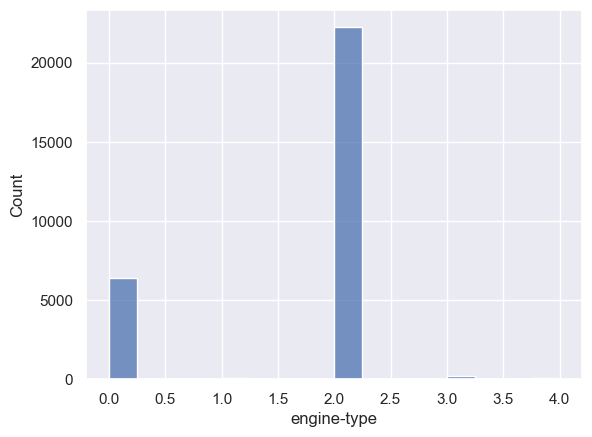

In [510]:
sns.histplot(data=train_X, x='engine-type')

In [511]:
# sns.pairplot(train_X[numerical]);


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


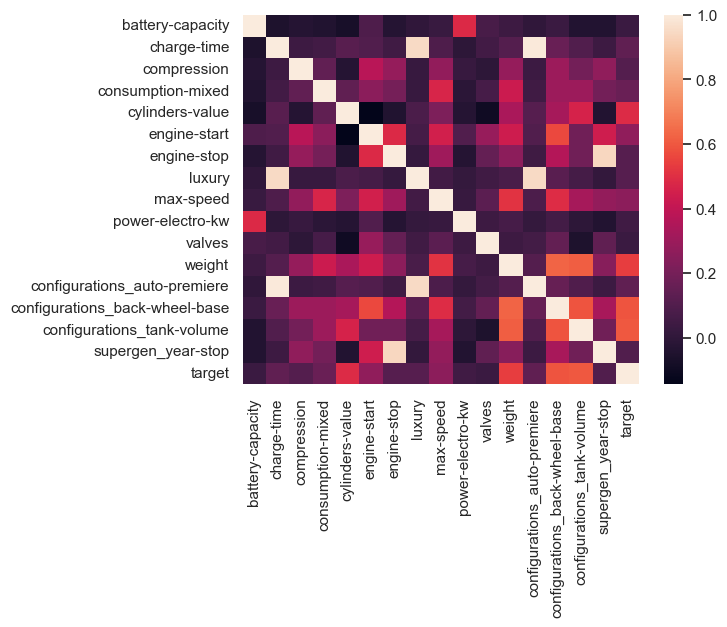

In [512]:
train = train_X[:]
train['target'] = train_y
sns.heatmap(train[numerical + ['target']].corr(method='spearman'));

In [513]:
from scipy.stats import pearsonr, spearmanr

r = pearsonr(train['configurations_auto-premiere'], train['target'])
print('Pearson correlation:', r[0], 'p-value:', r[1])

Pearson correlation: 0.11003752360955549 p-value: 9.72564682925814e-79


In [514]:
r = pearsonr(train['battery-capacity'], train['target'])
print('Pearson correlation:', r[0], 'p-value:', r[1])

Pearson correlation: 0.023665183667099604 p-value: 5.610547363610232e-05


## F-test

In [515]:
from sklearn.feature_selection import f_regression, SelectKBest

In [516]:
f_statistic, p_values = f_regression(train_X, train_y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [517]:
p_values

array([4.14261514e-178, 5.61054736e-005, 2.22583374e-084, 4.29215233e-006,
       5.19880608e-097, 0.00000000e+000, 0.00000000e+000, 3.00761649e-002,
       1.23407205e-153, 1.91780781e-122, 1.08128701e-102, 5.89170255e-038,
       1.18423856e-051, 6.73034264e-090, 6.04804785e-008, 3.29025321e-015,
       3.33873440e-033, 1.45689423e-002, 0.00000000e+000, 9.72564683e-079,
       6.46321123e-022, 5.15233301e-231, 8.63015515e-002, 0.00000000e+000,
       0.00000000e+000, 1.90641086e-122, 7.01981268e-140, 5.09638729e-005,
       4.56879391e-064, 3.51507643e-001])

In [518]:
sekector = SelectKBest(f_regression, k=20)
sekector.fit_transform(train_X, train_y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


array([[ 3.0000e+00,  1.1636e+04, -1.0000e+00, ...,  2.0000e+03,
         1.6000e+01,  0.0000e+00],
       [ 8.0000e+00,  3.1764e+04, -1.0000e+00, ...,  1.9960e+03,
         2.3000e+01,  0.0000e+00],
       [ 8.0000e+00,  2.7730e+03,  6.8000e+00, ...,  2.0120e+03,
         1.0000e+01,  0.0000e+00],
       ...,
       [ 3.0000e+00,  4.8819e+04,  7.6000e+00, ..., -1.0000e+00,
         2.6000e+01,  0.0000e+00],
       [ 1.0000e+01,  9.3460e+03, -1.0000e+00, ...,  1.9950e+03,
         1.6000e+01,  0.0000e+00],
       [ 3.0000e+00,  4.3309e+04, -1.0000e+00, ...,  2.0070e+03,
         3.5000e+01,  0.0000e+00]])

In [519]:
sekector.get_feature_names_out()

array(['back-suspension', 'charge-time', 'consumption-mixed',
       'cylinders-order', 'cylinders-value', 'engine-start',
       'engine-stop', 'engine-type', 'gear-type', 'luxury', 'max-speed',
       'valves', 'weight', 'configurations_auto-premiere',
       'configurations_front-brake', 'configurations_seats',
       'configurations_tank-volume', 'supergen_year-stop',
       'models_country-from', 'models_light-and-commercial'], dtype=object)

## Значения Шепли

In [520]:
import shap

In [521]:
reg = LinearRegression().fit(train_X, train_y)

In [522]:
explainer = shap.Explainer(reg, train_X)
shap_values = explainer(test_X)

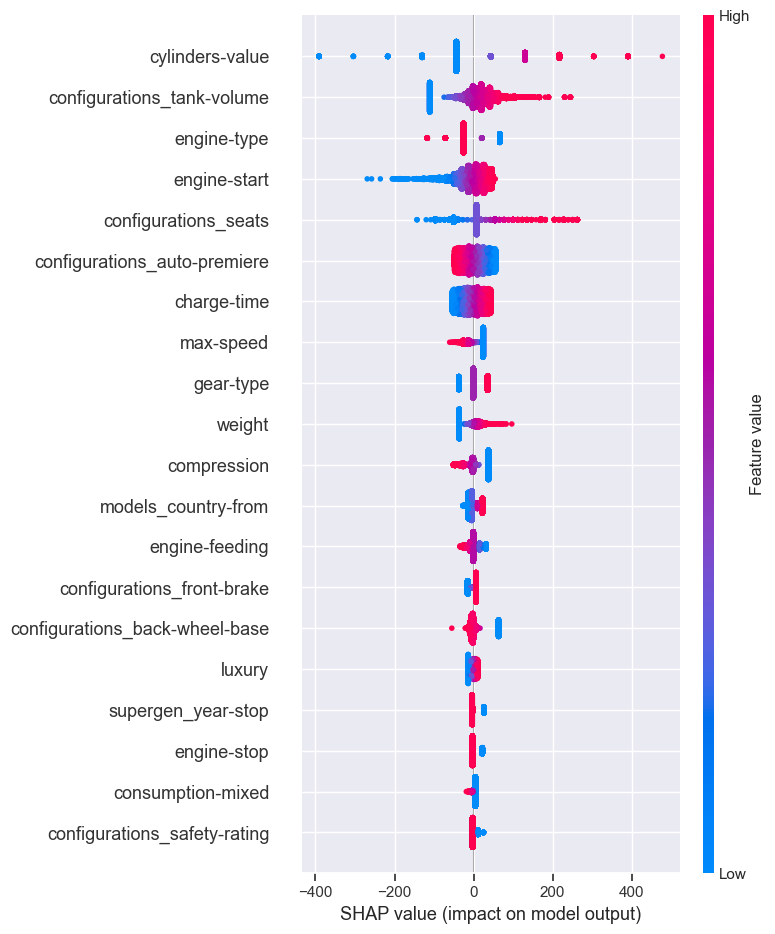

In [523]:
shap.summary_plot(shap_values, test_X)

Для признака cylinders-value наблюдается положительная статистическая зависимость от целевой переменной. Сравните Ваш результат с результатом работы библиотеки shap.

In [524]:
train_cut_X = train_X[train_X.columns[:5]]
test_cut_X = test_X[train_X.columns[:5]]

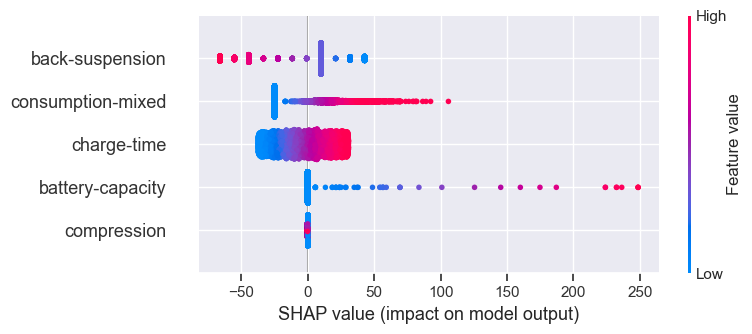

In [525]:
reg = LinearRegression().fit(train_cut_X, train_y)

explainer = shap.Explainer(reg, train_cut_X)
shap_values = explainer(test_cut_X)

shap.summary_plot(shap_values, test_cut_X)

In [526]:
shap_values

.values =
array([[-6.60946703e+01,  0.00000000e+00, -3.01313331e+01,
         1.21905783e-02, -2.49747176e+01],
       [-6.60946703e+01,  0.00000000e+00, -3.09092739e+01,
         1.17696994e-01, -2.49747176e+01],
       [-4.43171842e+01,  0.00000000e+00, -1.97078124e+01,
        -2.71793702e-03,  7.24113165e+00],
       ...,
       [ 1.01265310e+01,  0.00000000e+00, -1.08202262e+01,
         4.16291620e-03,  9.71927390e+00],
       [ 1.01265310e+01,  0.00000000e+00, -1.11792758e+01,
        -8.45198137e-03, -2.49747176e+01],
       [ 4.27927602e+01,  0.00000000e+00,  8.37673839e+00,
        -8.45198137e-03,  2.01274714e+01]])

.base_values =
array([2665.37993641, 2665.37993641, 2665.37993641, ..., 2665.37993641,
       2665.37993641, 2665.37993641])

.data =
array([[ 1.0000e+01, -1.0000e+00,  6.3840e+03,  8.2000e+00, -1.0000e+00],
       [ 1.0000e+01, -1.0000e+00,  5.6820e+03, -1.0000e+00, -1.0000e+00],
       [ 8.0000e+00, -1.0000e+00,  1.5790e+04,  9.5000e+00,  5.5000e+00],
       .

### Задание

Для сокращенных данных (train_cut_X и test_cut_X) реализовать метод отбора важности признаков по Шепли.

In [527]:
class MyShap:
    def __init__(self, train_X: pd.DataFrame, test_X: pd.DataFrame, train_y: pd.DataFrame, sample_size: float):
        self.train_X = train_X
        self.test_X = test_X
        self.train_y = train_y
        self.sample_size = sample_size

    def _powerset(self, iterable):
        "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
        s = list(iterable)
        return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

    def _get_shap_values_dict(self) -> dict:
        shap_values_dict = {}
        features = self.train_X.columns 
        for feature in features:
            subsets = self._powerset(self.train_X.columns[~(self.train_X.columns == feature)])
            fi_row_list = []
            sample_test_X = self.test_X.sample(int(round(self.sample_size * len(test_X), 0)))
            for i in tqdm(sample_test_X.index):
                fi_subset_list = []
                for subset in subsets[1:]:
                    subset = list(subset)
                    subset_with_feature = subset[:]
                    subset_with_feature.append(feature)
                    reg_with_feature = LinearRegression().fit(self.train_X[subset_with_feature], self.train_y).predict(pd.DataFrame(sample_test_X.loc[i, subset_with_feature]).T)
                    reg_without_feature = LinearRegression().fit(self.train_X[subset], self.train_y).predict(pd.DataFrame(sample_test_X.loc[i, subset]).T)
                    fi = math.factorial(len(subset)) * math.factorial((len(self.train_X.columns) - len(subset) - 1)) / math.factorial(len(self.train_X.columns)) * (reg_with_feature - reg_without_feature)
                    fi_subset_list.append(fi[0][0])
                fi_row_list.append(sum(fi_subset_list))
            shap_values_dict[feature] = [fi_row_list]
        return shap_values_dict

    def _get_shap_values_df(self, shap_values_dict: dict) -> pd.DataFrame:
        shap_values_df = pd.DataFrame(shap_values_dict).T.reset_index()
        shap_values_df.columns = ['feature', 'value']
        shap_values_df['mean_value'] = shap_values_df['value'].apply(lambda x: np.mean(x))
        shap_values_df['median_value'] = shap_values_df['value'].apply(lambda x: np.median(x))
        shap_values_df['abs_mean_value'] = shap_values_df['mean_value'].apply(lambda x: abs(x))
        shap_values_df['abs_median_value'] = shap_values_df['median_value'].apply(lambda x: abs(x))
        shap_values_df = shap_values_df.sort_values(by='abs_median_value', ascending=False).reset_index(drop=True)
        return shap_values_df

    def get_top_by_shap(self) -> pd.DataFrame:
        shap_values_dict = self._get_shap_values_dict()
        shap_values_df = self._get_shap_values_df(shap_values_dict)
        return shap_values_df

In [528]:
# my_shap = MyShap(train_cut_X, test_cut_X, train_y, 0.03)
# my_shap.get_top_by_shap()
# закомментил, чтоб не тормозило при запуске всех ячеек разом, а так код рабочий

## Пермутационная важность

In [529]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

In [530]:
reg = LinearRegression().fit(train_X, train_y)

In [531]:
perm = PermutationImportance(reg, random_state=42).fit(test_X, test_y)

In [532]:
eli5.show_weights(perm, feature_names=list(test_X.columns))

Weight,Feature
0.3617 ± 0.0044,cylinders-value
0.1035 ± 0.0039,configurations_tank-volume
0.0959 ± 0.0066,configurations_seats
0.0498 ± 0.0020,engine-type
0.0466 ± 0.0009,engine-start
0.0291 ± 0.0012,configurations_auto-premiere
0.0287 ± 0.0023,charge-time
0.0196 ± 0.0027,compression
0.0193 ± 0.0019,gear-type
0.0165 ± 0.0020,weight


### Задание

Самостоятельно реализовать алгоритм отбора признаков на основе пермутационной важности. Построить гистограмму полученных значений.

In [533]:
from sklearn.utils import shuffle
from sklearn.metrics import r2_score

class MyPermutationImportance:
    def __init__(self, model: LinearRegression, X: pd.DataFrame, y: pd.DataFrame, n_iteration: int):
        self.X = X
        self.y = y
        self.n_iteration = n_iteration

    def _get_permutation_importance_dict(self) -> dict:
        importance_dict = {}
        real_r2_score = r2_score(reg.predict(self.X), self.y)
        K = self.n_iteration
        for feature in tqdm(self.X.columns):
            r2_for_one_feature_list = []    
            for k in range(K):
                _X = self.X[:]
                shuffle_feature = shuffle(_X[feature]).tolist()
                _X[feature] = shuffle_feature
                r2_shuffle = r2_score(reg.predict(_X), self.y)
                r2_for_one_feature_list.append(r2_shuffle)
            importance_value = abs(real_r2_score - 1 / K * sum(r2_for_one_feature_list))
            importance_dict[feature] = [importance_value]
        return importance_dict

    def _get_permutation_importance_df(self, importance_dict : dict) -> pd.DataFrame:
        importance_df = pd.DataFrame(data=importance_dict).T.reset_index()
        importance_df.columns = ['feature', 'importance_value']
        importance_df.sort_values(by='importance_value', ascending=False, inplace=True)
        return importance_df

    def get_top_by_permutation_importance(self) -> pd.DataFrame:
        importance_dict = self._get_permutation_importance_dict()
        importance_df = self._get_permutation_importance_df(importance_dict)
        return importance_df

In [534]:
# reg = LinearRegression().fit(train_X, train_y)
# my_permutation_importance = MyPermutationImportance(reg, test_X, test_y, 100)
# importance_df = my_permutation_importance.get_top_by_permutation_importance()
# закомментил, чтоб не тормозило при запуске всех ячеек разом, а так код рабочий

In [535]:
# sns.barplot(data=importance_df, y='feature', x='importance_value')
# можно раскомментить вместе с ячейкой выше

# Домашнее задание

Сгенерировать полиномиальные признаки для рассматриваемого сегодня набора данных. Попробовать отобрать признаки различными методами (можно теми, что не рассматривали). Получить максимальное качество на тестовых данных. Проинтерпретировать результаты.

In [536]:
from sklearn.preprocessing import PolynomialFeatures

In [537]:
X

,back-suspension,battery-capacity,charge-time,compression,consumption-mixed,cylinders-order,cylinders-value,engine-feeding,engine-start,engine-stop,...,configurations_back-wheel-base,configurations_front-brake,configurations_safety-rating,configurations_seats,configurations_tank-volume,supergen_year-stop,models_country-from,models_group,models_light-and-commercial,models_male
0,9,-1.0,36457,9.0,4.3,0,3,4,2006,2018,...,1300.0,1,2,13,40.0,2018.0,16,3,0,1
1,3,-1.0,44872,8.0,-1.0,3,7,4,1982,1993,...,1555.0,4,2,13,108.0,1993.0,34,3,0,1
2,3,-1.0,55927,16.0,4.2,0,4,5,2014,2018,...,1534.0,4,2,13,55.0,2019.0,35,3,0,1
3,0,-1.0,41405,10.3,-1.0,0,4,4,2000,2003,...,1495.0,4,2,13,55.0,2003.0,10,3,0,1
4,8,-1.0,22523,19.0,-1.0,0,4,8,2000,2005,...,1515.0,4,1,13,62.0,2005.0,10,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43240,9,-1.0,34558,11.2,6.6,0,4,4,2004,2016,...,1425.0,1,2,13,47.0,2016.0,15,3,0,1
43241,3,-1.0,38268,9.6,5.8,0,4,2,2013,2015,...,1551.0,4,2,13,65.0,2015.0,10,3,0,1
43242,3,-1.0,8958,10.0,9.3,0,4,4,1991,1999,...,1460.0,4,2,13,55.0,1999.0,16,3,0,1
43243,3,-1.0,20293,8.5,-1.0,0,5,4,2002,2004,...,1548.0,1,2,13,70.0,2004.0,28,3,0,1


In [538]:
class MyScaler:
    def __init__(self):
        pass

    def fit(self, train_X):
        train_X = train_X.replace(-1, np.nan) 
        median_dict = {}
        for column in train_X.columns:
            median_dict[column] = np.nanmedian(train_X[column])
        return median_dict

    def transform(self, test_X, median_dict):
        test_X = test_X.replace(-1, np.nan)
        for column in test_X.columns:
            test_X[column] = test_X[column].fillna(median_dict[column])
        return test_X
    
    def fit_transform(self, data):
        median_dict = self.fit(data)
        output_data = self.transform(data, median_dict)
        return output_data, median_dict


In [539]:
# my_scaler = MyScaler()
# train_X, median_dict = my_scaler.fit_transform(train_X)
# test_X = my_scaler.transform(test_X, median_dict)
# при замене -1 возрастает качество регрессионной модели без доп. преобразований
# не производя замену, получим более высокое качество на модели с полиномиальными признаками с последующим отбором

In [540]:
base_model = reg.fit(train_X, train_y)
base_model.score(test_X, test_y)

0.46471537322321854

In [541]:
train_poly_X = pd.DataFrame(poly.fit_transform(train_X), columns=poly.get_feature_names_out())
test_poly_X = pd.DataFrame(poly.fit_transform(test_X), columns=poly.get_feature_names_out())

In [542]:
model_for_poly_X = LinearRegression().fit(train_poly_X, train_y)
model_for_poly_X.score(test_poly_X, test_y)

0.689680112106875

In [543]:
explainer = shap.Explainer(model_for_poly_X, train_poly_X)
shap_values = explainer(test_poly_X)

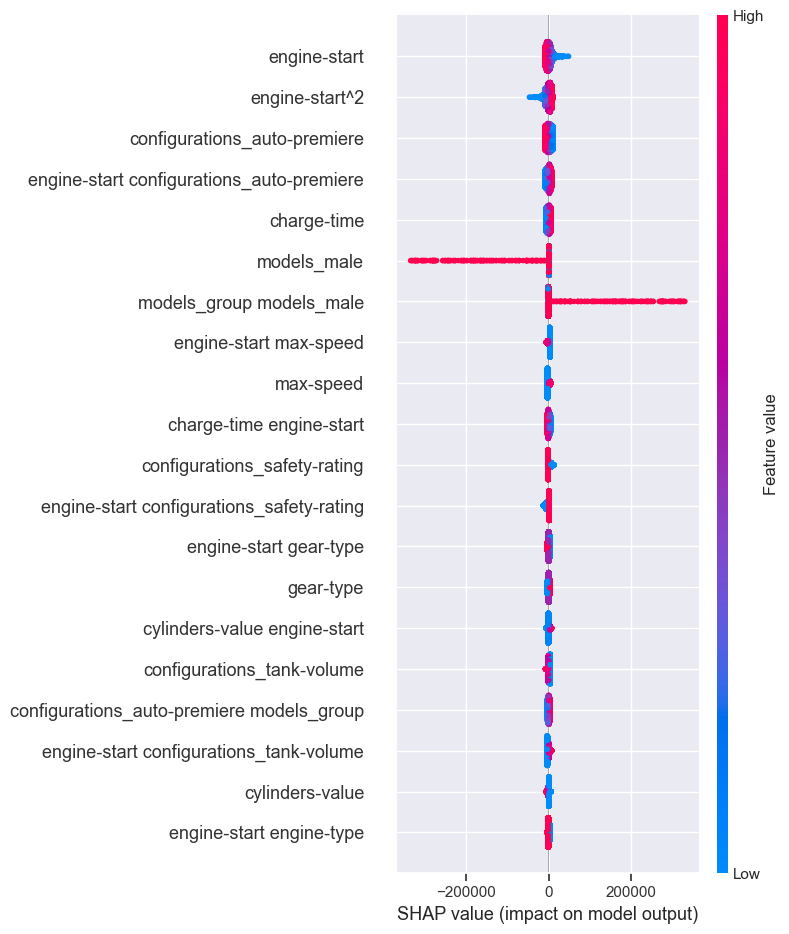

In [544]:
shap.summary_plot(shap_values, test_poly_X)

In [545]:
top_by_shap = ['engine-start', 'engine-start^2', 'configurations_auto-premiere', 'engine-start configurations_auto-premiere', 'charge-time', 'models_male', 'models_group models_male']

In [546]:
models_for_top_by_shap = LinearRegression().fit(train_poly_X[top_by_shap], train_y)

In [547]:
models_for_top_by_shap.score(test_poly_X[top_by_shap], test_y)

0.08653996388936491

In [548]:
perm = PermutationImportance(model_for_poly_X, random_state=42).fit(test_poly_X, test_y)

In [549]:
eli5.show_weights(perm, feature_names=list(test_poly_X.columns))

Weight,Feature
13392.0968 ± 279.6280,models_male
13073.7988 ± 219.3884,models_group models_male
1533.1784 ± 26.3040,engine-start
1511.8342 ± 15.1870,engine-start^2
1190.4904 ± 4.8041,configurations_auto-premiere
698.7959 ± 10.6811,engine-start configurations_auto-premiere
408.7303 ± 8.9843,charge-time
206.6449 ± 2.7175,configurations_safety-rating
203.7623 ± 4.8800,engine-start configurations_safety-rating
165.4958 ± 2.4955,engine-start max-speed


*Результаты отбора при помощи значений Шепли и пермутационной важности схожи.*

*Мои варианты реализации расчета значений Шепли и пермутационной важности уступают в быстродействии вариантам выше, так что оставим их для меньших наборов данных.*

In [550]:
sel = SelectFromModel(perm, threshold=0.001, prefit=True)

In [551]:
select_train_X, select_test_X = sel.transform(train_poly_X), sel.transform(test_poly_X)

X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names


In [552]:
select_model = LinearRegression().fit(select_train_X, train_y)
select_model.score(select_test_X, test_y)

0.6904224816251006

In [553]:
select_train_X.shape

(28974, 366)

In [554]:
train_poly_X.shape

(28974, 496)